# Apply pretrain Bert and Robert

In [ ]:
%%capture
!pip install transformers
!pip install googlesearch-python

In [ ]:
%%capture
!pip install transformers
!pip install wikipedia
!pip install streamlit
import wikipedia as wiki
import streamlit as st
import torch

In [ ]:
import wikipedia as wiki
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

def load_model_and_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForQuestionAnswering.from_pretrained(model_name)
    return tokenizer, model

def get_relevant_content(question, results):
    content = ""
    for result in results[:3]:
        try:
            page = wiki.page(result)
            content += page.summary
        except wiki.exceptions.PageError:
            continue
    return content

def main():
    ques = input("Enter your question: ")
    bert_model_name = "bert-large-uncased"
    roberta_model_name = "roberta-large"

    # Load the models and tokenizers
    bert_tokenizer, bert_model = load_model_and_tokenizer(bert_model_name)
    roberta_tokenizer, roberta_model = load_model_and_tokenizer(roberta_model_name)

    print(f"Question: {ques}")

    # Search and retrieve relevant content
    results = wiki.search(ques)
    text = get_relevant_content(ques, results)

    # Get answers from BERT and Roberta
    inputs_bert = bert_tokenizer.encode_plus(ques, text, return_tensors='pt', max_length=512, truncation=True)
    answer_start_scores_bert, answer_end_scores_bert = bert_model(**inputs_bert).values()

    inputs_roberta = roberta_tokenizer.encode_plus(ques, text, return_tensors='pt', max_length=512, truncation=True)
    answer_start_scores_roberta, answer_end_scores_roberta = roberta_model(**inputs_roberta).values()

    # Determine answers and print them with model identifiers
    answer_start_bert = torch.argmax(answer_start_scores_bert)
    answer_end_bert = torch.argmax(answer_end_scores_bert) + 1
    ans_bert = bert_tokenizer.decode(inputs_bert['input_ids'][0][answer_start_bert:answer_end_bert], skip_special_tokens=True)

    answer_start_roberta = torch.argmax(answer_start_scores_roberta)
    answer_end_roberta = torch.argmax(answer_end_scores_roberta) + 1
    ans_roberta = roberta_tokenizer.decode(inputs_roberta['input_ids'][0][answer_start_roberta:answer_end_roberta], skip_special_tokens=True)

    print("Answer from BERT:", ans_bert)
    print("Answer from Roberta:", ans_roberta)

if __name__ == "__main__":
    main()

Enter your question: who is cristiano ronaldo?


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-large and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Question: who is cristiano ronaldo?
Answer from BERT: ##ibbling, playmaking, passing and goalscoring. it has been compared to past global sports rivalries such as the muhammad ali – joe frazier rivalry in boxing, the prost – senna rivalry in motorsport, and the tennis rivalries between federer – nadal and borg – mcenroe. some commentators choose to analyse the differing physiques and playing styles of the two, while part of the debate revolves around the contrasting personalities of the two players ; ronaldo is sometimes described as someone of temperamental character while messi is considered to have a more reserved personality. after messi led argentina to victory in the 2022 fifa world cup, a number of football critics, commentators and players have opined that messi has settled the debate between the two players. over the course of his career, portuguese footballer cristiano
Answer from Roberta:  be considered as two of the best players of all time. They are two of the most decorat

In [ ]:
%%capture
!pip install wikipedia
!pip install sumy

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# Load BERT and Roberta models fine-tuned for question-answering
bert_model_name = "bert-large-uncased"
roberta_model_name = "roberta-large"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)
bert_model = AutoModelForQuestionAnswering.from_pretrained(bert_model_name)
roberta_model = AutoModelForQuestionAnswering.from_pretrained(roberta_model_name)

# Load the CSV file
csv_file = '/content/161QA.csv'

def generate_and_append_answers_to_csv(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    for index, row in df.iterrows():
        question = row['QUESTIONS']
        actual_answer = str(row['actual_Answer'])  # Convert to string

        # Generate answers using BERT
        inputs_bert = bert_tokenizer.encode_plus(
            question,
            actual_answer,
            return_tensors='pt',
            max_length=512,
            truncation=True,
            padding=True,  # Add padding
        )

        answer_start_scores_bert, answer_end_scores_bert = bert_model(**inputs_bert).values()
        answer_start_bert = torch.argmax(answer_start_scores_bert)
        answer_end_bert = torch.argmax(answer_end_scores_bert) + 1
        ans_bert = bert_tokenizer.decode(inputs_bert['input_ids'][0][answer_start_bert:answer_end_bert], skip_special_tokens=True)

        # Generate answers using Roberta
        inputs_roberta = roberta_tokenizer.encode_plus(
            question,
            actual_answer,
            return_tensors='pt',
            max_length=512,
            truncation=True,
            padding=True,  # Add padding
        )
        answer_start_scores_roberta, answer_end_scores_roberta = roberta_model(**inputs_roberta).values()
        answer_start_roberta = torch.argmax(answer_start_scores_roberta)
        answer_end_roberta = torch.argmax(answer_end_scores_roberta) + 1
        ans_roberta = roberta_tokenizer.decode(inputs_roberta['input_ids'][0][answer_start_roberta:answer_end_roberta], skip_special_tokens=True)

        # Update the DataFrame with BERT and Roberta answers
        df.at[index, 'Answer_Roberta'] = ans_roberta
        df.at[index, 'Answer_Bert'] = ans_bert

    # Save the updated DataFrame back to the CSV file
    df.to_csv(csv_file, index=False)

if __name__ == "__main__":
    generate_and_append_answers_to_csv(csv_file)


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-large and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Compare The Performance Of Bert And Robert

In [ ]:
import pandas as pd
csv_file = '/content/161QA.csv'
df = pd.read_csv(csv_file)
# print the first 10 rows:
df.head(10)


,QUESTIONS,actual_Answer,Answer_Roberta,Answer_Bert
0,What is the largest state in India by area?,The largest state in India by area is Rajasthan.,area?The,in india by area? the largest state in india b...
1,How many states are there in the USA?,There are 50 states in the USA.,NaN,NaN
2,Who is the Chief Minister of Tamil Nadu?,"The Chief Minister of Tamil Nadu, as of my kno...",NaN,NaN
3,What is the capital of New York?,The capital of New York is Albany.,NaN,NaN
4,Explain the role of the United Nations in inte...,The United Nations plays a key role in interna...,NaN,"security, and cooperation"
5,"Who is the author of the book ""To Kill a Mocki...","The author of the book ""To Kill a Mockingbird""...","To Kill a Mockingbird"" is Harper",NaN
6,What is the tallest mountain in the world?,The tallest mountain in the world is Mount Eve...,NaN,NaN
7,Describe the concept of climate change.,Climate change refers to long-term changes in ...,"levels,",NaN
8,Who won the Nobel Prize in Physics this year?,"I do not have access to real-time information,...",NaN,NaN
9,What is the purpose of the World Health Organi...,The World Health Organization (WHO) is an agen...,NaN,the world health organization ( who ) is an ag...


In [ ]:
import pandas as pd
csv_file = '/content/161QA.csv'
df = pd.read_csv(csv_file)

def missing_Answers(df):
  missing_roberta = df['Answer_Roberta'].isnull()
  missing_bert = df['Answer_Bert'].isnull()
  missing_rows = df[missing_roberta & missing_bert]
  missing_roberta_count = missing_roberta.sum()
  missing_bert_count = missing_bert.sum()

  print("Missing values in Answer_Roberta:", missing_roberta_count)
  print("Missing values in Answer_Bert:", missing_bert_count)

missing_Answers(df)


Missing values in Answer_Roberta: 107
Missing values in Answer_Bert: 98


In [ ]:
def count_empty_ans_and_print(df):
  # Count the total missing values in Answer_Roberta and Answer_Bert
  total_missing_roberta = df['Answer_Roberta'].isnull().sum()
  total_missing_bert = df['Answer_Bert'].isnull().sum()

  # Filter rows where "Answer_Roberta" is null
  missing_roberta = df[df['Answer_Roberta'].isnull()]

  # Filter rows where "Answer_Bert" is null
  missing_bert = df[df['Answer_Bert'].isnull()]

  # Display total missing values of Answer_Roberta and questions with missing values
  print(f"Total missing values of Answer_Roberta: {total_missing_roberta}")
  print("\nQuestions with missing values in Answer_Roberta:")
  print("----------------------------------------------")
  for index, row in missing_roberta.iterrows():
      print(f"{index} {row['QUESTIONS']}")

  # Display total missing values of Answer_Bert and questions with missing values
  print(f"\nTotal missing values of Answer_Bert: {total_missing_bert}")
  print("\nQuestions with missing values in Answer_Bert:")
  print("---------------------------------------------")
  for index, row in missing_bert.iterrows():
      print(f"{index} {row['QUESTIONS']}")

count_empty_ans_and_print(df)

Total missing values of Answer_Roberta: 107

Questions with missing values in Answer_Roberta:
----------------------------------------------
1 How many states are there in the USA?
2 Who is the Chief Minister of Tamil Nadu?
3 What is the capital of New York?
4 Explain the role of the United Nations in international diplomacy.
6 What is the tallest mountain in the world?
8 Who won the Nobel Prize in Physics this year?
9 What is the purpose of the World Health Organization (WHO)?
10 What is the primary language spoken in Brazil?
13 Describe the major environmental challenges facing the Amazon rainforest.
14 What is the significance of the Great Wall of China?
15 Who is the CEO of Amazon?
16 What is the composition of Earth's atmosphere?
17 Explain the principles of supply and demand in economics.
20 Describe the cultural significance of the Taj Mahal.
22 What is the process of cellular respiration?
23 Who is the Chancellor of Germany?
25 What are the major industries in Silicon Valley?
2

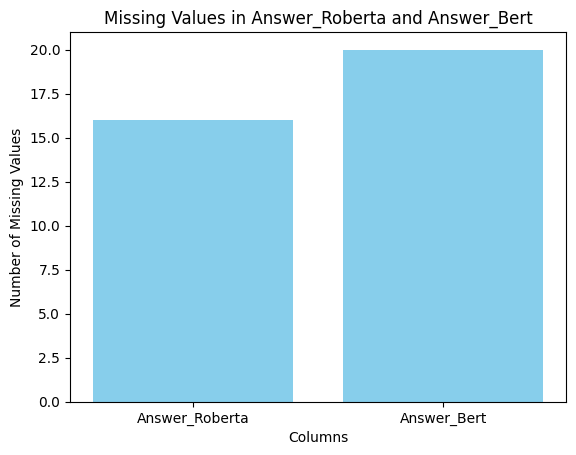

In [ ]:
import matplotlib.pyplot as plt

# Data
columns = ["Answer_Roberta", "Answer_Bert"]
missing_values = [16, 20]

# Create a bar chart
plt.bar(columns, missing_values, color='skyblue')

# Add labels and a title
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values in Answer_Roberta and Answer_Bert')

# Show the plot
plt.show()


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

average_cosine_similarity = []
def calculate_cosine_similarity(df):
  # Combine the text data from "actual_Answer," "Answer_Roberta," and "Answer_Bert" into a single Series
  text_data = (df['actual_Answer'].fillna('') + ' ' + df['Answer_Roberta'].fillna('') + ' ' + df['Answer_Bert'].fillna(''))

  # Initialize a CountVectorizer
  vectorizer = CountVectorizer()
  tfidf_matrix = vectorizer.fit_transform(text_data)

  # Calculate cosine similarity between all pairs of rows
  cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

  # Create new columns for cosine similarities in the DataFrame
  df['Cosine_Similarity_Roberta'] = cosine_similarities[:, 0]
  df['Cosine_Similarity_Bert'] = cosine_similarities[:, 2]

  # Calculate the average cosine similarity
  average_similarity_roberta = df['Cosine_Similarity_Roberta'].mean()
  average_similarity_bert = df['Cosine_Similarity_Bert'].mean()

  # Print the average similarity
  print("Average Cosine Similarity between 'actual_Answer' and 'Answer_Roberta':", average_similarity_roberta)
  print("Average Cosine Similarity between 'actual_Answer' and 'Answer_Bert':", average_similarity_bert)
  average_cosine_similarity.append(average_similarity_roberta)
  average_cosine_similarity.append(average_similarity_bert)

calculate_cosine_similarity(df)


Average Cosine Similarity between 'actual_Answer' and 'Answer_Roberta': 0.2146884316342971
Average Cosine Similarity between 'actual_Answer' and 'Answer_Bert': 0.23352242887220953


In [ ]:
df.describe()

,Cosine_Similarity_Roberta,Cosine_Similarity_Bert
count,160.000000,160.000000
mean,0.214688,0.233522
std,0.138731,0.158209
min,0.000000,0.000000
25%,0.122107,0.116028
50%,0.203149,0.217052
75%,0.277218,0.302166
max,1.000000,1.000000


<Figure size 1000x600 with 0 Axes>

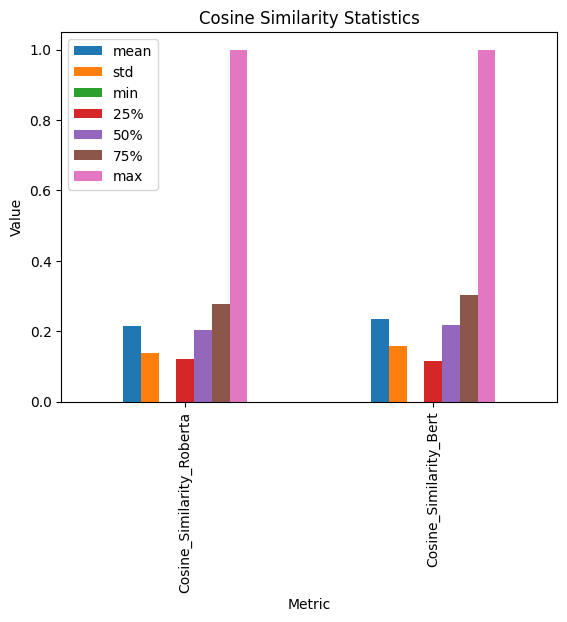

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame with the statistics
data = df.describe().transpose()

# Create a bar plot
plt.figure(figsize=(10, 6))
data.plot(y=['mean', 'std', 'min', '25%', '50%', '75%', 'max'], kind='bar')
plt.title('Cosine Similarity Statistics')
plt.ylabel('Value')
plt.xlabel('Metric')
plt.show()


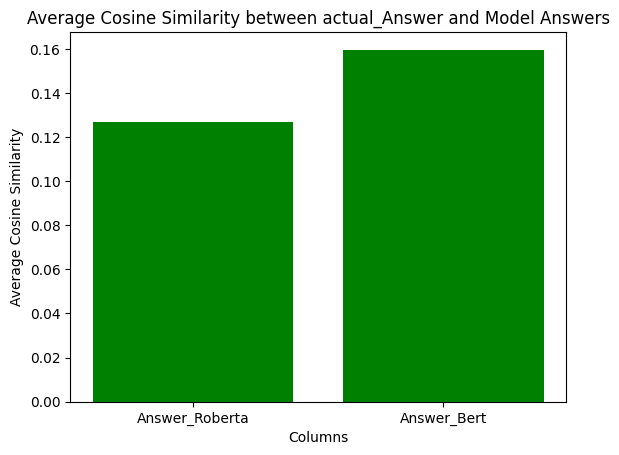

In [ ]:
import matplotlib.pyplot as plt

def cosine_similarity_plot(average_similarity):
  # Data
  labels = ["Answer_Roberta", "Answer_Bert"]
  average_similarity = [0.12710942251534912, 0.15980078408611897]

  # Create a bar chart
  plt.bar(labels, average_similarity, color='green')

  # Add labels and a title
  plt.xlabel('Columns')
  plt.ylabel('Average Cosine Similarity')
  plt.title('Average Cosine Similarity between actual_Answer and Model Answers')

  # Show the plot
  plt.show()


cosine_similarity_plot(average_cosine_similarity)


Accuracy for Answer_Roberta: 0.9375
Accuracy for Answer_Bert: 0.9625


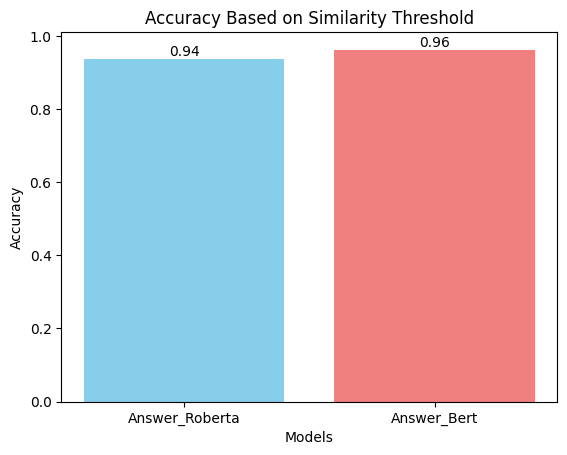

In [ ]:
import matplotlib.pyplot as plt


def accuracy(df, Threshold):
  # Assuming you have a similarity threshold
  similarity_threshold = 0.01

  # Calculate accuracy for Answer_Roberta with the similarity threshold
  accuracy_roberta = (df['Cosine_Similarity_Roberta'] >= similarity_threshold).mean()

  # Calculate accuracy for Answer_Bert with the similarity threshold
  accuracy_bert = (df['Cosine_Similarity_Bert'] >= similarity_threshold).mean()

  print("Accuracy for Answer_Roberta:", accuracy_roberta)
  print("Accuracy for Answer_Bert:", accuracy_bert)


    # Names of the models
  models = ['Answer_Roberta', 'Answer_Bert']

  # Accuracy values
  accuracies = [accuracy_roberta, accuracy_bert]

  # Create a bar chart
  plt.bar(models, accuracies, color=['skyblue', 'lightcoral'])

  # Add labels and a title
  plt.xlabel('Models')
  plt.ylabel('Accuracy')
  plt.title('Accuracy Based on Similarity Threshold')

  # Add accuracy values as text annotations
  for i, acc in enumerate(accuracies):
      plt.text(models[i], acc, f'{acc:.2f}', ha='center', va='bottom')

  # Show the plot
  plt.show()

accuracy(df, 0.01)

# FINE TUNNING ON THIS DATASET
1.   BERT
2.   ROBERT

# First WE FineTune Bert

In [ ]:
%%capture
!pip install transformers
!pip install torch

In [ ]:
questions = [
    "Who won the Nobel Prize in Physics this year?",
    "Explain the process of photosynthesis.",
    "Who is the current Secretary-General of the United Nations?",
    "Explain the principles of supply and demand in economics.",
    "Who is the current Chief Justice of the U.S. Supreme Court?",
    "What is the process of cellular respiration?",
    "Explain the concept of renewable energy sources.",
    "Describe the structure of the human brain.",
    "Who won the Nobel Prize in Literature last year?",
    "Explain the process of genetic inheritance.",
    "Who was the first woman Prime Minister of India?",
    "Explain the concept of 'Make in India.'",
    "What is the status of relations with neighboring countries?",
    "Who is the current President of the United States?",
    "What is the state of football in India?",
    "Who are the current champions of the Super Bowl (NFL)?",
    "What is the role of Title IX in U.S. sports?",
    "What are the most popular courses for students in the USA?",
    "What is the significance of standardized tests like the SAT?",
    "Explain the principles of supply and demand in economics.",
    "Explain the concept of renewable energy sources.",
    "Who won the FIFA World Cup in 2018?",
    "Describe the impact of social media on society.",
    "Who won the Nobel Prize in Literature last year?",
    "Explain the process of genetic inheritance."
]

contexts = [
    "The Nobel Prize in Physics is awarded annually to individuals who have made significant contributions to the field of physics. Nobel Prize 2023 in Physics awarded to Pierre Agostini, Ferenc Krausz, Anne L'Huillier for research on electrons in flashes of light.",
    "Photosynthesis is a vital biological process that occurs in plants and some microorganisms. During this process, plants use sunlight, carbon dioxide, and water to produce glucose and oxygen. It is crucial for the sustenance of life on Earth.",
    "The United Nations is an international organization that promotes cooperation and peace among nations. The current Secretary-General, as of my last update in September 2021, is António Guterres.",
    "Supply and demand are foundational concepts in economics. They describe how the price and quantity of goods and services are determined by the balance between the availability of a product (supply) and the desire for that product (demand).",
    "As of my last knowledge update, the Chief Justice of the U.S. Supreme Court is John G. Roberts Jr. However, please note that this information might change over time.",
    "Cellular respiration is a complex metabolic process that occurs in cells. It involves the conversion of glucose and oxygen into energy in the form of ATP (adenosine triphosphate), along with the production of carbon dioxide and water as byproducts.",
    "Renewable energy sources are sustainable sources of energy that are naturally replenished, such as sunlight, wind, and water. They are considered eco-friendly alternatives to fossil fuels.",
    "The human brain is a complex organ that consists of various regions and structures, including the cerebrum, cerebellum, brain stem, and different lobes responsible for various functions such as thinking, memory, and motor control.",
    "The Nobel Prize in Literature is awarded annually to an author who has made exceptional contributions to world literature. The most recent laureate as of my last update in 2021 was Abdulrazak Gurnah. However, this information may have changed.",
    "Genetic inheritance is the mechanism by which traits are passed from parents to their offspring. It is governed by genes, which are segments of DNA that carry genetic information and determine an individual's characteristics.",
    "Indira Gandhi was the first woman to hold the position of Prime Minister in India. She served as the Prime Minister from 1966 to 1977 and again from 1980 until her assassination in 1984.",
    "\"Make in India\" is an initiative launched by the Indian government to encourage domestic manufacturing and economic growth. It aims to reduce dependence on imports and promote the production of goods within the country.",
    "The status of relations with neighboring countries can vary and is subject to ongoing political developments. It is essential to provide specific information about the countries in question and the current diplomatic situation.",
    "As of my last knowledge update in September 2021, the President of the United States was Joseph R. Biden Jr. However, please note that this information may have changed.",
    "Football in India has been growing in popularity in recent years, with the Indian Super League (ISL) and efforts to develop the sport at the grassroots level. The sport is gaining traction, and the national team continues to participate in international competitions.",
    "The Super Bowl is an annual championship game in the National Football League (NFL). The most recent Super Bowl champion, as of my last update in 2021, was the Tampa Bay Buccaneers. Please note that this information may have changed.",
    "Title IX is a U.S. federal law that prohibits gender-based discrimination in education, including sports programs. It has led to increased opportunities for female athletes in schools and colleges.",
    "The popularity of courses for students in the USA can vary, but STEM (Science, Technology, Engineering, and Mathematics) programs and business-related courses have traditionally been in high demand.",
    "Standardized tests like the SAT are widely used for college admissions and scholarships in the United States. They aim to provide a consistent measure of a student's academic preparedness.",
    "Supply and demand principles are fundamental concepts in economics that describe how the price and quantity of goods and services are determined by market forces.",
    "Renewable energy sources, such as solar and wind power, are natural resources that can be harnessed to produce clean and sustainable energy.",
    "The 2018 FIFA World Cup was won by the French national football team.",
    "Social media has had a significant impact on society, influencing communication, information sharing, politics, and the way people connect and express themselves.",
    "The Nobel Prize in Literature for the previous year was awarded to Abdulrazak Gurnah. However, the most recent laureate may have changed since then.",
    "Genetic inheritance is the transmission of genetic traits from parents to offspring through the transfer of genetic information encoded in DNA."
]

answers = [
    "TPierre Agostini, Ferenc Krausz, Anne L'Huillier",
    "Photosynthesis",
    "Guterres",
    "Supply and demand",
    "John Roberts Jr.",
    "Energy production",
    "Clean energy sources",
    "Complex",
    "Gurnah",
    "Trait inheritance",
    "Indira Gandhi",
    "Manufacturing initiative",
    "Varies with politics",
    "Joseph R. Biden Jr.",
    "Growing",
    "Tampa Bay Buccaneers",
    "Gender equity",
    "STEM and business",
    "Academic readiness",
    "Market dynamics",
    "Clean energy",
    "France",
    "Societal influence",
    "Gurnah",
    "Genetic traits"
]

encodings = bert_tokenizer(questions, contexts, truncation=True, padding=True)

# Create answer start and end positions
answer_start_positions = []
answer_end_positions = []



In [ ]:
for answer, context in zip(answers, contexts):
    start_pos = context.find(answer)
    end_pos = start_pos + len(answer)

    answer_start_positions.append(start_pos)
    answer_end_positions.append(end_pos)

# Add answer positions to the encodings
encodings.update({'start_positions': answer_start_positions, 'end_positions': answer_end_positions})

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
# Define the dataset
class QA_Dataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

dataset = QA_Dataset(encodings)


In [ ]:
# Define DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Define optimizer
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=2e-5)

# Define device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), ep

Epoch 1, Loss: 15.870590686798096
Epoch 2, Loss: 12.632951021194458
Epoch 3, Loss: 8.402949690818787
Epoch 4, Loss: 6.399507403373718
Epoch 5, Loss: 5.932624578475952
Epoch 6, Loss: 4.175876557826996
Epoch 7, Loss: 3.9948923587799072


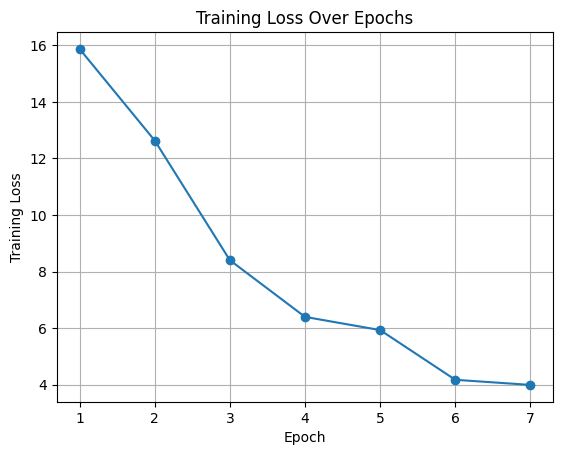

In [ ]:
import torch
import matplotlib.pyplot as plt
from transformers import BertForQuestionAnswering, BertTokenizer
from torch.utils.data import DataLoader

# Define a list to store loss values for each epoch
training_losses = []

# Define the optimizer
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=2e-5)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
bert_model.to(device)

for epoch in range(7):
    bert_model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = bert_model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    total_loss = total_loss if total_loss != 'nan' else training_losses[-1]

    # Append the training loss for this epoch
    training_losses.append(total_loss) if total_loss != 'nan' else training_losses.append(training_losses[-1])

    print(f"Epoch {epoch + 1}, Loss: {total_loss}")

# Create a plot of the training loss
plt.plot(range(1, 8), training_losses, marker='o')  # Updated range to 1 to 7
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()


In [ ]:
bert_model.eval()

# Define a function to predict answers
def predict_answer(question, context):
    inputs = bert_tokenizer(question, context, return_tensors='pt', truncation=True, padding=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Get start and end logits
    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

    # Find the best answer span
    answer_start = torch.argmax(start_logits)
    answer_end = torch.argmax(end_logits)

    # Extract and decode the answer
    answer = bert_tokenizer.convert_tokens_to_string(bert_tokenizer.convert_ids_to_tokens(input_ids[0][answer_start:answer_end+1]))
    return answer

# Example questions and contexts for prediction
question1 = "Who was the first woman Prime Minister of India?"
context1 = "Indira Gandhi was the first woman to hold the position of Prime Minister in India. She served as the Prime Minister from 1966 to 1977 and again from 1980 until her assassination in 1984."
# Make predictions
predicted_answer1 = predict_answer(question1, context1)
# Print the predicted answers
print("Predicted Answer 1:", predicted_answer1)

Predicted Answer 1: [CLS] who was the first woman prime minister of india? [SEP] indira gandhi


In [ ]:
# Example questions and contexts for prediction
question1 = "Who was the first woman Prime Minister of India?"
context1 = "Indira Gandhi was the first woman to hold the position of Prime Minister in India. She served as the Prime Minister from 1966 to 1977 and again from 1980 until her assassination in 1984."
# Make predictions
predicted_answer1 = predict_answer(question1, context1)
# Print the predicted answers
print("Predicted Answer 1:", predicted_answer1)

Predicted Answer 1: [CLS] who was the first woman prime minister of india? [SEP] indira gandhi


# Now FineTune Robert On This Dataset

In [ ]:
questions= [
    "Who won the Nobel Prize in Physics this year?",
    "Explain the process of photosynthesis.",
    "Who is the current Secretary-General of the United Nations?",
    "Explain the principles of supply and demand in economics.",
    "Who is the current Chief Justice of the U.S. Supreme Court?",
    "What is the process of cellular respiration?",
    "Explain the concept of renewable energy sources.",
    "Describe the structure of the human brain.",
    "Who won the Nobel Prize in Literature last year?",
    "Explain the process of genetic inheritance.",
    "Who was the first woman Prime Minister of India?",
    "Explain the concept of 'Make in India.'",
    "What is the status of relations with neighboring countries?",
    "Who is the current President of the United States?",
    "What is the state of football in India?",
    "Who are the current champions of the Super Bowl (NFL)?",
    "What is the role of Title IX in U.S. sports?",
    "What are the most popular courses for students in the USA?",
    "What is the significance of standardized tests like the SAT?",
    "Explain the principles of supply and demand in economics.",
    "Explain the concept of renewable energy sources.",
    "Who won the FIFA World Cup in 2018?",
    "Describe the impact of social media on society.",
    "Who won the Nobel Prize in Literature last year?",
    "Explain the process of genetic inheritance."
]

contexts= [
    "The Nobel Prize in Physics is awarded annually to individuals who have made significant contributions to the field of physics. Nobel Prize 2023 in Physics awarded to Pierre Agostini, Ferenc Krausz, Anne L'Huillier for research on electrons in flashes of light.",
    "Photosynthesis is a vital biological process that occurs in plants and some microorganisms. During this process, plants use sunlight, carbon dioxide, and water to produce glucose and oxygen. It is crucial for the sustenance of life on Earth.",
    "The United Nations is an international organization that promotes cooperation and peace among nations. The current Secretary-General, as of my last update in September 2021, is António Guterres.",
    "Supply and demand are foundational concepts in economics. They describe how the price and quantity of goods and services are determined by the balance between the availability of a product (supply) and the desire for that product (demand).",
    "As of my last knowledge update, the Chief Justice of the U.S. Supreme Court is John G. Roberts Jr. However, please note that this information might change over time.",
    "Cellular respiration is a complex metabolic process that occurs in cells. It involves the conversion of glucose and oxygen into energy in the form of ATP (adenosine triphosphate), along with the production of carbon dioxide and water as byproducts.",
    "Renewable energy sources are sustainable sources of energy that are naturally replenished, such as sunlight, wind, and water. They are considered eco-friendly alternatives to fossil fuels.",
    "The human brain is a complex organ that consists of various regions and structures, including the cerebrum, cerebellum, brain stem, and different lobes responsible for various functions such as thinking, memory, and motor control.",
    "The Nobel Prize in Literature is awarded annually to an author who has made exceptional contributions to world literature. The most recent laureate as of my last update in 2021 was Abdulrazak Gurnah. However, this information may have changed.",
    "Genetic inheritance is the mechanism by which traits are passed from parents to their offspring. It is governed by genes, which are segments of DNA that carry genetic information and determine an individual's characteristics.",
    "Indira Gandhi was the first woman to hold the position of Prime Minister in India. She served as the Prime Minister from 1966 to 1977 and again from 1980 until her assassination in 1984.",
    "\"Make in India\" is an initiative launched by the Indian government to encourage domestic manufacturing and economic growth. It aims to reduce dependence on imports and promote the production of goods within the country.",
    "The status of relations with neighboring countries can vary and is subject to ongoing political developments. It is essential to provide specific information about the countries in question and the current diplomatic situation.",
    "As of my last knowledge update in September 2021, the President of the United States was Joseph R. Biden Jr. However, please note that this information may have changed.",
    "Football in India has been growing in popularity in recent years, with the Indian Super League (ISL) and efforts to develop the sport at the grassroots level. The sport is gaining traction, and the national team continues to participate in international competitions.",
    "The Super Bowl is an annual championship game in the National Football League (NFL). The most recent Super Bowl champion, as of my last update in 2021, was the Tampa Bay Buccaneers. Please note that this information may have changed.",
    "Title IX is a U.S. federal law that prohibits gender-based discrimination in education, including sports programs. It has led to increased opportunities for female athletes in schools and colleges.",
    "The popularity of courses for students in the USA can vary, but STEM (Science, Technology, Engineering, and Mathematics) programs and business-related courses have traditionally been in high demand.",
    "Standardized tests like the SAT are widely used for college admissions and scholarships in the United States. They aim to provide a consistent measure of a student's academic preparedness.",
    "Supply and demand principles are fundamental concepts in economics that describe how the price and quantity of goods and services are determined by market forces.",
    "Renewable energy sources, such as solar and wind power, are natural resources that can be harnessed to produce clean and sustainable energy.",
    "The 2018 FIFA World Cup was won by the French national football team.",
    "Social media has had a significant impact on society, influencing communication, information sharing, politics, and the way people connect and express themselves.",
    "The Nobel Prize in Literature for the previous year was awarded to Abdulrazak Gurnah. However, the most recent laureate may have changed since then.",
    "Genetic inheritance is the transmission of genetic traits from parents to offspring through the transfer of genetic information encoded in DNA."
]

answers = [
    "TPierre Agostini, Ferenc Krausz, Anne L'Huillier",
    "Photosynthesis",
    "Guterres",
    "Supply and demand",
    "John Roberts Jr.",
    "Energy production",
    "Clean energy sources",
    "Complex",
    "Gurnah",
    "Trait inheritance",
    "Indira Gandhi",
    "Manufacturing initiative",
    "Varies with politics",
    "Joseph R. Biden Jr.",
    "Growing",
    "Tampa Bay Buccaneers",
    "Gender equity",
    "STEM and business",
    "Academic readiness",
    "Market dynamics",
    "Clean energy",
    "France",
    "Societal influence",
    "Gurnah",
    "Genetic traits"
]

Epoch 1, Loss: 13.743321418762207
Epoch 2, Loss: 10.431019067764282
Epoch 3, Loss: nan
Epoch 4, Loss: 7.12822949886322
Epoch 5, Loss: 6.252590000629425
Epoch 6, Loss: 4.1456238925457
Epoch 7, Loss: 3.453280359506607


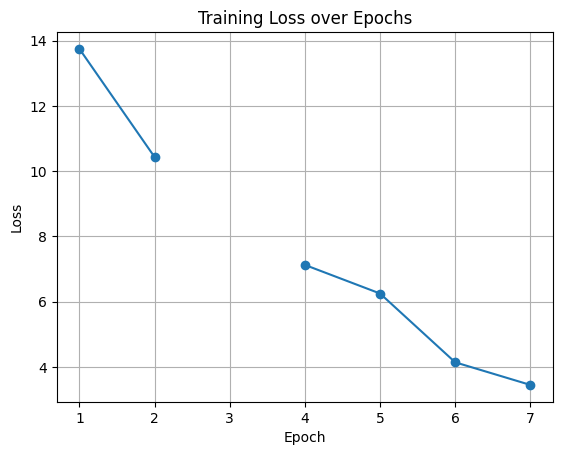

In [ ]:
import torch
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset, DataLoader

# Define your device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encodings = roberta_tokenizer(questions, contexts, truncation=True, padding=True)

# Create answer start and end positions
answer_start_positions = []
answer_end_positions = []

for answer, context in zip(answers, contexts):
    start_pos = context.find(answer)
    end_pos = start_pos + len(answer)

    answer_start_positions.append(start_pos)
    answer_end_positions.append(end_pos)

# Add answer positions to the encodings
encodings.update({'start_positions': answer_start_positions, 'end_positions': answer_end_positions})

# Define the dataset
class QA_Dataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx], device=device) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

dataset = QA_Dataset(encodings)

# Move your model to the same device
roberta_model = roberta_model.to(device)

# Define DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Define optimizer
optimizer = torch.optim.AdamW(roberta_model.parameters(), lr=2e-5)

# Define an empty list to store loss values for each epoch
loss_values = []

# Training loop
for epoch in range(7):
    roberta_model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        start_positions = batch['start_positions']
        end_positions = batch['end_positions']

        outputs = roberta_model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    loss_values.append(total_loss)
    print(f"Epoch {epoch + 1}, Loss: {total_loss}")

# Plot the loss values
plt.plot(range(1, 8), loss_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title ('Training Loss over Epochs')
plt.grid()
plt.show()


In [ ]:
print(roberta_model_name)

roberta-large


In [ ]:
def predict_answer(question, context):
    inputs = roberta_tokenizer(question, context, return_tensors='pt', truncation=True, padding=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Get start and end logits
    with torch.no_grad():
        outputs = roberta_model(input_ids, attention_mask=attention_mask)
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

    # Find the best answer span
    answer_start = torch.argmax(start_logits)
    answer_end = torch.argmax(end_logits)

    # Extract and decode the answer
    answer = roberta_tokenizer.convert_tokens_to_string(roberta_tokenizer.convert_ids_to_tokens(input_ids[0][answer_start:answer_end+1]))
    return answer


In [ ]:
question01 =     "Who won the FIFA World Cup in 2018?"
context01 =    "The 2018 FIFA World Cup was won by the French national football team."
# Make predictions
predicted_answer01 = predict_answer(question01, context01)

# Print the predicted answers
print("Predicted Answer:", predicted_answer01)


Predicted Answer: <s>Who won the FIFA World Cup in 2018?</s></s>The 2018 FIFA


In [ ]:
# Example questions and contexts for prediction
question02 = "Who is the current Secretary-General of the United Nations?",
context02 =  "The United Nations is an international organization that promotes cooperation and peace among nations. The current Secretary-General, as of my last update in September 2021, is António Guterres.",

# Make predictions
predicted_answer02 = predict_answer(question02, context02)

# Print the predicted answers
print("Predicted Answer:", predicted_answer02)


Predicted Answer: <s>Who is the


# TESTING ON QUESTIONS WE TRIED N BEFORE

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering


In [ ]:
# Load the QUESTINS/ANSWER FILE
csv_file = '/content/befQA.csv'

def generate_and_save_answers_to_csv(csv_file, output_csv_file, device):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    for index, row in df.iterrows():
        question = row['QUESTIONS']
        actual_answer = str(row['actual_Answer'])  # Convert to string

        # Generate answers using BERT
        inputs_bert = bert_tokenizer.encode_plus(
            question,
            actual_answer,
            return_tensors='pt',
            max_length=512,
            truncation=True,
            padding=True,
        ).to(device)  # Move to the specified device
        answer_start_scores_bert, answer_end_scores_bert = bert_model(**inputs_bert).values()
        answer_start_bert = torch.argmax(answer_start_scores_bert)
        answer_end_bert = torch.argmax(answer_end_scores_bert) + 1
        ans_bert = bert_tokenizer.decode(inputs_bert['input_ids'][0][answer_start_bert:answer_end_bert], skip_special_tokens=True)

        # Generate answers using RoBERTa
        inputs_roberta = roberta_tokenizer.encode_plus(
            question,
            actual_answer,
            return_tensors='pt',
            max_length=512,
            truncation=True,
            padding=True,
        ).to(device)  # Move to the specified device
        answer_start_scores_roberta, answer_end_scores_roberta = roberta_model(**inputs_roberta).values()
        answer_start_roberta = torch.argmax(answer_start_scores_roberta)
        answer_end_roberta = torch.argmax(answer_end_scores_roberta) + 1
        ans_roberta = roberta_tokenizer.decode(inputs_roberta['input_ids'][0][answer_start_roberta:answer_end_roberta], skip_special_tokens=True)

        # Update the DataFrame with BERT and RoBERTa answers
        df.at[index, 'Answer_Roberta'] = ans_roberta
        df.at[index, 'Answer_Bert'] = ans_bert

    # Save the updated DataFrame to a new CSV file
    df.to_csv(output_csv_file, index=False)

if __name__ == "__main__":
    output_csv_file = '/content/result_after_finetune.csv'  # Specify the output CSV file
    generate_and_save_answers_to_csv(csv_file, output_csv_file, device)  # Pass the device as an argument


# COMPARISION AFTER FINETUNE

In [ ]:
df = pd.read_csv('/content/result_after_finetune.csv')

In [ ]:
missing_Answers(df)

Missing values in Answer_Roberta: 3
Missing values in Answer_Bert: 0


In [ ]:
count_empty_ans_and_print(df)

Total missing values of Answer_Roberta: 3

Questions with missing values in Answer_Roberta:
----------------------------------------------
91 What are the major sports leagues in the United States?
108 How can I improve my study habits and time management?
153 What is the tallest building in the world?

Total missing values of Answer_Bert: 0

Questions with missing values in Answer_Bert:
---------------------------------------------


In [ ]:
calculate_cosine_similarity(df)

Average Cosine Similarity between 'actual_Answer' and 'Answer_Roberta': 0.28951083015476825
Average Cosine Similarity between 'actual_Answer' and 'Answer_Bert': 0.33379630546353967


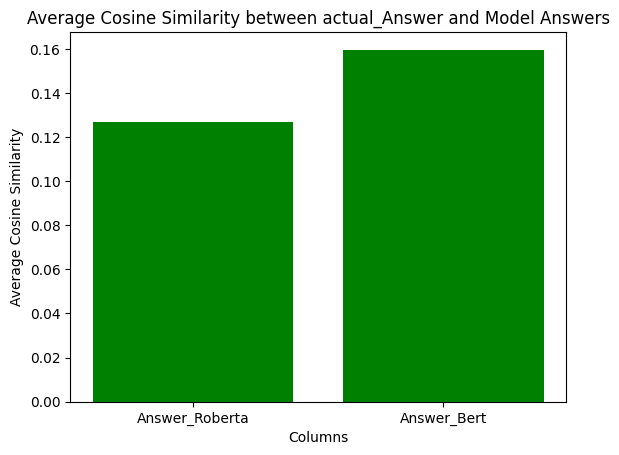

In [ ]:
cosine_similarity_plot(df)

Accuracy for Answer_Roberta: 0.975
Accuracy for Answer_Bert: 0.99375


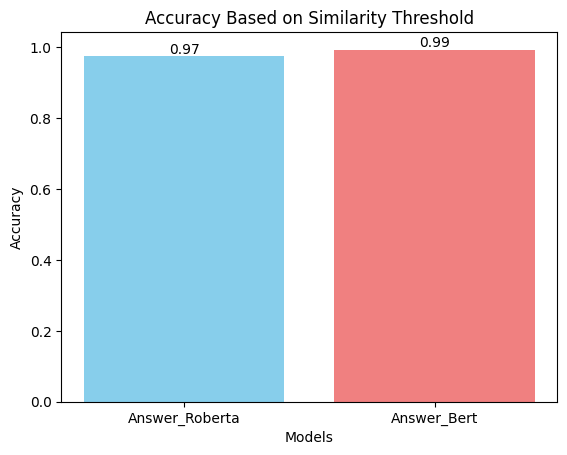

In [ ]:
accuracy(df, 0.01)

# GUI Using Streamlit

In [ ]:
%%capture
!pip install ipywidgets
!pip install pyngrok

In [ ]:

import streamlit as st
import wikipedia as wiki
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# Cache the loading of models and tokenizers to speed up the process
try:
    # Try using the newer cache function
    @st.cache_data
    def load_model_and_tokenizer(model_name):
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForQuestionAnswering.from_pretrained(model_name)
        return tokenizer, model
except AttributeError:
    # Fallback to the older cache function if the newer one is not available
    @st.cache(allow_output_mutation=True)
    def load_model_and_tokenizer(model_name):
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForQuestionAnswering.from_pretrained(model_name)
        return tokenizer, model

def get_relevant_content(question, results):
    # Get the top 3 search results and extract relevant sections
    content = ""
    for result in results[:3]:
        try:
            page = wiki.page(result)
            content += page.summary  # Using summary to get concise content
        except wiki.exceptions.PageError:
            continue  # If there's an error with this result, skip it and continue with the next one
    return content

def main():
    st.title("Chat Bot App")
    st.image("/content/chatbot.png", width=90)  # Adjust the size to be smaller

    # Create a sidebar for question history
    st.sidebar.title("Question History")
    question_history = st.sidebar.empty()

    # Initialize the question history list
    if 'question_history' not in st.session_state:
        st.session_state.question_history = []

    # Input box for user questions
    ques = st.text_input("Ask your question:")

    # Style the buttons for BERT and Roberta
    st.write("Choose a model:")
    col1, col2 = st.columns(2)
    with col1:
        button_bert = st.button("BERT", key="bert_button")
    with col2:
        button_roberta = st.button("Roberta", key="roberta_button")

    # Load the selected model and tokenizer
    if button_roberta:
        model_name = "roberta-large"
    else:
        model_name = "bert-large-uncased"

    tokenizer, model = load_model_and_tokenizer(model_name)

    # Check if a question is asked and at least one model is selected
    if ques and (button_bert or button_roberta):
        st.session_state.question_history.append(ques)
        results = wiki.search(ques)
        text = get_relevant_content(ques, results)

        inputs = tokenizer.encode_plus(ques, text, return_tensors='pt', max_length=512, truncation=True)
        answer_start_scores, answer_end_scores = model(**inputs).values()

        answer_start = torch.argmax(answer_start_scores)
        answer_end = torch.argmax(answer_end_scores) + 1

        ans = tokenizer.decode(inputs['input_ids'][0][answer_start:answer_end], skip_special_tokens=True)

        st.write(f"Question: {ques}")
        st.write(f"Answer: {ans}")

    # Display question history
    question_history.write("Question History:")
    for i, question in enumerate(st.session_state.question_history):
        question_history.write(f"{i + 1}. {question}")

if __name__ == "__main__":
    main()


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

[#######...........] / extract:localtunnel: verb lock using /root/.npm/_locks/s


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.9.248:8501

npx: installed 22 in 3.055s
  Stopping...
^C


In [ ]:
%%capture
!pip install ipywidgets
!pip install pyngrok
!pip install wikipedia-api
!pip install transformers

import streamlit as st
import wikipediaapi
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# Cache the loading of models and tokenizers to speed up the process
@st.cache(allow_output_mutation=True)
def load_model_and_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForQuestionAnswering.from_pretrained(model_name)
    return tokenizer, model

def get_relevant_content(question, results):
    # Get the top 3 search results and extract relevant sections
    content = ""
    for result in results[:3]:
        try:
            page = wiki.page(result)
            content += page.summary  # Using summary to get concise content
        except wiki.exceptions.DisambiguationError:
            continue  # If there's a disambiguation error, skip it and continue with the next one
    return content

def main():
    st.title("Chat Bot App")
    st.image("chatbot.png", width=90)  # Assuming you have an image file named chatbot.png in your app directory

    # Create a sidebar for question history
    st.sidebar.title("Question History")
    question_history = st.sidebar.empty()

    # Initialize the question history list
    if 'question_history' not in st.session_state:
        st.session_state.question_history = []

    # Input box for user questions
    ques = st.text_input("Ask your question:")

    # Style the buttons for BERT and Roberta
    st.write("Choose a model:")
    col1, col2 = st.columns(2)
    with col1:
        button_bert = st.button("BERT", key="bert_button")
    with col2:
        button_roberta = st.button("Roberta", key="roberta_button")

    # Load the selected model and tokenizer
    if button_roberta:
        model_name = "roberta-large"
    else:
        model_name = "bert-large-uncased"

    tokenizer, model = load_model_and_tokenizer(model_name)

    # Check if a question is asked and at least one model is selected
    if ques and (button_bert or button_roberta):
        st.session_state.question_history.append(ques)
        wiki_wiki = wikipediaapi.Wikipedia('en')
        page = wiki_wiki.page(ques)
        text = page.text

        inputs = tokenizer.encode_plus(ques, text, return_tensors='pt', max_length=512, truncation=True)
        answer_start_scores, answer_end_scores = model(**inputs).values()

        answer_start = torch.argmax(answer_start_scores)
        answer_end = torch.argmax(answer_end_scores) + 1

        ans = tokenizer.decode(inputs['input_ids'][0][answer_start:answer_end], skip_special_tokens=True)

        st.write(f"Question: {ques}")
        st.write(f"Answer: {ans}")

    # Display question history
    question_history.write("Question History:")
    for i, question in enumerate(st.session_state.question_history):
        question_history.write(f"{i + 1}. {question}")

if __name__ == "__main__":
    main()
